Задание **Ultra pro**

По подготовленным на занятии данным, создайте обучающую, тестовую и проверочную выборки. 

По сформированным данным необходимо обучить модель для предсказания цены машины. Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен. Это можно сделать с помощью следующего метода:

predict_inverse = y_scaler.inverse_transform(predict).flatten()

где predict - результат предсказания модели).

Затем подсчитайте среднюю ошибку на тестовой выборке, среднюю цену и средний процент ошибки.

Рекомендации:

В качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).

Метрику для данной задачи можно не использовать.

Последний слой модели должен иметь 1 нейрон.

In [ ]:
# Для начала импортируем все необходимые в работе библиотеки
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, Adadelta
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing


# Для начала подготовим данные, которые потребуются для обучения нейронной сети

In [ ]:
# Загрузм файл с данными
files.upload()
!ls

Saving cars_new.csv to cars_new.csv
cars_new.csv  sample_data


In [ ]:
# Считаем файл с помощью pandas
cars = pd.read_csv('cars_new.csv', sep=',')

# Посмотрим с какими данными имеем дело
cars.head()    

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [ ]:
# Создаем словарь 
def create_dict(s):
  ret = {}
  for _id, name in enumerate(s):
    ret.update({name: _id})
  return ret

# Создадим функцию, которая будет преобразововать значения в one hot encoding
def to_ohe(value,d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr


In [ ]:
# Из всех текстовых колонок создаем словарь. Это нужно потому что нейронная сеть не работает с буквами(символами). Только с цифрами
marks_dict = create_dict(set(cars.mark))
models_dict = create_dict(set(cars.model))
bodies_dict = create_dict(set(cars.body))
kpps_dict = create_dict(set(cars.kpp))
fuels_dict = create_dict(set(cars.fuel))


In [ ]:
# Присвоим переменной значения колонки с ценами
prices = np.array(cars.price, dtype=np.float)
print (type(prices))
print (prices)

<class 'numpy.ndarray'>
[ 996000.  140200.  750000. ... 1140000.  550550.  430000.]


In [ ]:
# В переменные запишем нормированный результат всех числовых колонок
years = preprocessing.scale(cars.year)
mileages = preprocessing.scale(cars.mileage)
volumes = preprocessing.scale(cars.volume)
powers = preprocessing.scale(cars.power)

# Создание выборок для обучения и проверки

In [ ]:
# Для начала создадим пустую обучающую выборку
X =[]
Y = []

In [ ]:
# Создадим цикл для прохода по всем машинам
for _id, car in enumerate(np.array(cars)):
  Y.append(prices[_id])                 # цены автомобилей

  # Объеденяем все параметры в один большой вектор
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + \
         [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  
  # Добавляем этот вектор в список x_train
  X.append(x_tr)

In [ ]:
# Посмотрим какие значения в Y - цены на автомобилей
Y[:5]    # первые 5 

[996000.0, 140200.0, 750000.0, 970000.0, 205000.0]

In [ ]:
# Из списка делаем numpy массив
X = np.array(X, dtype=np.float)
Y = np.array(Y, dtype=np.float)

In [ ]:
# Для лучшей работы сети нормализуем значения коорые хранятся в y_train
y_scaler = StandardScaler()
Y = y_scaler.fit_transform(Y.reshape(-1,1)).flatten()

Y[:5]

array([ 0.75082432, -0.62135434,  0.3563911 ,  0.70913625, -0.51745486])

In [ ]:
# Полный набор данных. Который нужно разделить на выборки (обучающую, проверочную и тестовую)
print (X.shape)
print (Y.shape) 

(70119, 3208)
(70119,)


In [ ]:
# С помощью функции train_test_split разделим выборки (на обучающую и тестовую)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True)   #Параметр shuffle можно указывать, а можно нет, все равно данные идут не по порядку какому-нибудь

In [ ]:
# Далее с помощью такого же метода разделим обучающую выборку на (обучающую и проверочную)
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

In [ ]:
# Посмотрим размерность обучающей, проверочной и тестовой выборок после разделения.

print ("Обучающая выборка:")
print (x_train_new.shape)
print (y_train_new.shape) 

print ("\nПроверочная выборка:")
print (x_val.shape)
print (y_val.shape) 

print ("\nТестовая выборка:")
print (x_test.shape)
print (y_test.shape) 

Обучающая выборка:
(47680, 3208)
(47680,)

Проверочная выборка:
(11921, 3208)
(11921,)

Тестовая выборка:
(10518, 3208)
(10518,)


# Создание и обучение нейронной сети

In [ ]:
model_ula = Sequential()

# Добавляем слои  (4 Dense слоя и слои Dropout и BatchNormalization, которые можно раскомментировать для теста сети)
# C слоями Dropout сеть давала результаты хуже - обучать будем без этого слоя

model_ula.add(Dense(500, input_dim=3208, activation='relu'))     # 3208 - входные данные
model_ula.add(BatchNormalization())
#model_ula.add(Dropout(0.2))

model_ula.add(Dense(300, activation='relu'))
model_ula.add(BatchNormalization())
#model_ula.add(Dropout(0.2))

model_ula.add(Dense(100, activation='relu'))
model_ula.add(BatchNormalization())
#model_ula.add(Dropout(0.2))

model_ula.add(Dense(1, activation='linear'))

In [ ]:
model_ula.compile(loss='mse', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
history = model_ula.fit(x_train, y_train, batch_size=1000, epochs=15, verbose=1, validation_data=(x_val, y_val))

Epoch 1/15
60/60 [==============================] - 11s 190ms/step - loss: 0.0270 - accuracy: 0.0000e+00 - val_loss: 0.0154 - val_accuracy: 0.0000e+00
Epoch 2/15
60/60 [==============================] - 11s 180ms/step - loss: 0.0266 - accuracy: 0.0000e+00 - val_loss: 0.0183 - val_accuracy: 0.0000e+00
Epoch 3/15
60/60 [==============================] - 11s 188ms/step - loss: 0.0254 - accuracy: 0.0000e+00 - val_loss: 0.0147 - val_accuracy: 0.0000e+00
Epoch 4/15
60/60 [==============================] - 11s 176ms/step - loss: 0.0248 - accuracy: 0.0000e+00 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 5/15
60/60 [==============================] - 10s 175ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - val_loss: 0.0148 - val_accuracy: 0.0000e+00
Epoch 6/15
60/60 [==============================] - 10s 173ms/step - loss: 0.0250 - accuracy: 0.0000e+00 - val_loss: 0.0140 - val_accuracy: 0.0000e+00
Epoch 7/15
60/60 [==============================] - 10s 175ms/step - loss: 0.0238 - accuracy: 

In [ ]:
model_ula.save_weights('model_ula loss:0.0243 - val_loss:0.0146.h5')   # Можно сохранить веса на всякий случай

# Оценка качества работы созданной сети

**Средняя ошибка на тестовой выборке:**

In [ ]:
# Получаем предсказание на тестовой выборке
prediction = model_ula.predict(x_test)
prediction 

array([[-0.2195502 ],
       [-0.5578712 ],
       [ 0.46462718],
       ...,
       [-0.4344345 ],
       [-0.63611716],
       [ 0.70773745]], dtype=float32)

In [ ]:
# Перевод предсказанной моделью значений к первоначальному диапазону цен
predict_inverse = y_scaler.inverse_transform(prediction).flatten()
predict_inverse

array([390797.1 , 179793.12, 817504.6 , ..., 256778.1 , 130992.73,
       969127.6 ], dtype=float32)

In [ ]:
# Переводем значения y_test к первоначальному диапазону цен (были нормированы)
y_test_inverse = y_scaler.inverse_transform(y_test).flatten()
y_test_inverse

array([500000., 185000., 720000., ..., 289000., 205000., 850000.])

In [ ]:
# Найдем среднее значение ошибки. Для этого подсчитаем разницу каждой из предсказанных цен и действительными и разделим на их количество в выборке

sum = 0
# Пройдемся циклом по всем значениям 
for i in range(len(x_test)):
  diff = abs(predict_inverse[i] - y_test_inverse[i])    # Разница по модулю между предсказанной ценой и действительной
  sum += diff                                          # Сумма всех разниц цен по тестовой выборке

average_error = sum / len(x_test)                    # Средняя ошибка
average_error

59261.11493471199

In [ ]:
# Проверка на тестовой выборке
scores = model_ula.evaluate(x_test, y_test, verbose=1)
scores[0]

329/329 [==============================] - 2s 6ms/step - loss: 0.0861 - accuracy: 0.0000e+00


0.08605910837650299

**Средняя цена на тестовой выборке:**

In [ ]:
# Надем среднюю цену всех автомобилей в тестовой выборке (предсказанной сетью)
s1 = np.sum(predict_inverse) / len(x_test)   # Сумма всех цен автомобилей деленная на их кол-во в тестовой выборке
s1

531935.4827914052

In [ ]:
# Средняя цена на реальных данных из тестовой выборке
s2 = np.sum(y_test_inverse) / len(y_test)
s2

539121.2779045446

In [ ]:
# Погрешность между средними ценами в предсказанных ценами и действительными 
s = abs(s1-s2)
s


7185.795113139437

**Средний процент ошибки на тестовой выборке:**

In [ ]:
# Чтобы найти средний процент ошибки нам следует найти разницу каждой из предсказанных цен и действительной ценой, и разделить ее на действительную цену
# далее просуммировать все полученные значения и умножить на 100
sum = 0
# Пройдемся циклом по всем значениям 
for i in range(len(x_test)):
  diff = abs(predict_inverse[i] - y_test_inverse[i]) / y_test_inverse[i]   # Разница по модулю между предсказанной ценой и действительной деленная на действительную цену
  sum += diff                                                              # Сумма всех этих значений

percent_test = sum / len(y_test_inverse) * 100
print ("Средний процент ошибки на тестовой выборке:", percent_test)

Средний процент ошибки на тестовой выборке: 18.894176597566123


**Определение среднего процента ошибки на проверочной выборке:**

In [ ]:
# По аналогии с вычислениями процента ошибка на тестовой выборке, высчитаем данную ошибку на проверочной. 

prediction_val = model_ula.predict(x_val)

predict_inverse_val = y_scaler.inverse_transform(prediction_val).flatten()

y_val_inverse = y_scaler.inverse_transform(y_val).flatten()

sum_val = 0
# Пройдемся циклом по всем значениям 
for i in range(len(x_val)):
  diff_val = abs(predict_inverse_val[i] - y_val_inverse[i]) / y_val_inverse[i]   # Разница по модулю между предсказанной ценой и действительной деленная на действительную цену
  sum_val += diff_val                                                             # Сумма всех этих значений

percent_val = (sum_val / len(y_val_inverse)) * 100
print ("Средний процент ошибки на тестовой выборке:", percent_val)

Средний процент ошибки на тестовой выборке: 15.127335986072332


# Можно построить и вывести график ошибки при обучении нейронной сети

In [ ]:
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
%matplotlib inline

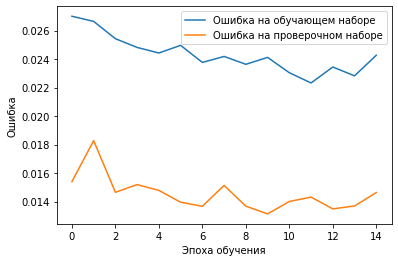

In [ ]:
#Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()